# TTC Headway Analysis (WIP 2)
Mohamed Osman - 19 Oct 2019

The 'headway' is the length of time between the arrival times of two consecutive trains at a given station. Using historical TTC arrival data (Bloor-Danforth Eastbound, September 2019), we can do some preliminary analyses involving that metric.

In [386]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.dates as mdates

pd.set_option('display.max_rows', 200)
plt.rcParams["figure.figsize"] = (20,10)

## Read in data

In [387]:
polls = pd.read_csv('polls.csv');
requests = pd.read_csv('requests.csv');
responses = pd.read_csv('responses.csv');

## Create initial dataset
The datasets *requests.csv* and *responses.csv* () will be used for this analysis.

*requests.csv* is a dataset consisting of logs relating to the scraper interacting with TTC's API. Each request is a batch of arrival times for a station, or the next n trains to arrive at a station, with each batch being uniquely identified by a *request_id*. *request_date* is the timestamp for a request, assumed to be the exact time where the request data was retrieved by the API.

*responses.csv* includes all of the requests obtained by the scraper. Each row documents one arrival time for a train towards a station, including an assortment of qualitative and quantatative data for each one. Each row is associated with a *request_id*.

The first thing we want to do is merge *request_date* with *responses.csv* on *request_id* so we have a timestamp associated with each row.

In [388]:
# merge responses with request dates
ttc_init = pd.merge(responses,requests[['requestid','request_date']],on='requestid')

# only want to look at eastbound (xxx1) Bloor-Danforth lines for now
ttc_init = ttc_init.loc[ttc_init['station_char'].str.endswith('1')].loc[ttc_init['subwayline'] == 'BD']

# sort data by estimated time, station, and request date (ascending)
ttc_init = ttc_init.sort_values(by=['station_char','request_date','timint'])
ttc_init.head(30)

,requestid,id,station_char,subwayline,system_message_type,timint,traindirection,trainid,train_message,train_dest,request_date
399192,71598,32906400104,BAT1,BD,Normal,18.180275,East,212,Arriving,Westbound<br/> To Kipling,2019-09-01 08:00:40.360236-04:00
252684,45263,32906407828,BAT1,BD,Normal,17.096017,East,212,Arriving,Westbound<br/> To Kipling,2019-09-01 08:01:40.611312-04:00
373463,66959,32906417292,BAT1,BD,Normal,16.334302,East,212,Arriving,Westbound<br/> To Kipling,2019-09-01 08:02:40.803525-04:00
162856,28965,32906422671,BAT1,BD,Normal,15.484518,East,212,Arriving,Westbound<br/> To Kipling,2019-09-01 08:03:40.704256-04:00
166091,29554,32906431750,BAT1,BD,Normal,14.601168,East,212,Arriving,Westbound<br/> To Kipling,2019-09-01 08:04:40.621257-04:00
401886,72156,32906438204,BAT1,BD,Normal,13.666171,East,212,Arriving,Westbound<br/> To Kipling,2019-09-01 08:05:48.279228-04:00
97631,17408,32906443305,BAT1,BD,Normal,11.910410,East,212,Arriving,Westbound<br/> To Kipling,2019-09-01 08:06:40.423118-04:00
335051,59941,32906448729,BAT1,BD,Normal,11.225104,East,212,Arriving,Westbound<br/> To Kipling,2019-09-01 08:07:40.762114-04:00
150302,26737,32906453789,BAT1,BD,Normal,10.314667,East,212,Arriving,Westbound<br/> To Kipling,2019-09-01 08:08:40.446002-04:00
163191,29037,32906458285,BAT1,BD,Normal,9.184731,East,212,Arriving,Westbound<br/> To Kipling,2019-09-01 08:09:40.824793-04:00


## Transform dataset
Ideally, before calculating headway, we would want to transform our dataset and remove unnecessary arrival times so that each row catalogs the next upcoming train for a station. The train can either be arriving, or can already be at the station. Once we have that, calculating headway will be very simple.

This will be done in several steps.

### Requests
Each request has data on the next n (up to 3) trains to arrive at a station. We only care about the earliest train for each request, so we'll remove the rest from the dataset. Since the dataset is already sorted ascendingly by *request_date* and *timint*, the time until arrival, we can simply remove subsequent duplicates of the same *request_id*.

In [389]:
# one request => three arrival times in ascending order
# only need first upcoming train, so only keep that for each request batch
ttc_1 = ttc_init.copy().drop_duplicates(subset='requestid')
ttc_1.head(30)

,requestid,id,station_char,subwayline,system_message_type,timint,traindirection,trainid,train_message,train_dest,request_date
399192,71598,32906400104,BAT1,BD,Normal,18.180275,East,212,Arriving,Westbound<br/> To Kipling,2019-09-01 08:00:40.360236-04:00
252684,45263,32906407828,BAT1,BD,Normal,17.096017,East,212,Arriving,Westbound<br/> To Kipling,2019-09-01 08:01:40.611312-04:00
373463,66959,32906417292,BAT1,BD,Normal,16.334302,East,212,Arriving,Westbound<br/> To Kipling,2019-09-01 08:02:40.803525-04:00
162856,28965,32906422671,BAT1,BD,Normal,15.484518,East,212,Arriving,Westbound<br/> To Kipling,2019-09-01 08:03:40.704256-04:00
166091,29554,32906431750,BAT1,BD,Normal,14.601168,East,212,Arriving,Westbound<br/> To Kipling,2019-09-01 08:04:40.621257-04:00
401886,72156,32906438204,BAT1,BD,Normal,13.666171,East,212,Arriving,Westbound<br/> To Kipling,2019-09-01 08:05:48.279228-04:00
97631,17408,32906443305,BAT1,BD,Normal,11.910410,East,212,Arriving,Westbound<br/> To Kipling,2019-09-01 08:06:40.423118-04:00
335051,59941,32906448729,BAT1,BD,Normal,11.225104,East,212,Arriving,Westbound<br/> To Kipling,2019-09-01 08:07:40.762114-04:00
150302,26737,32906453789,BAT1,BD,Normal,10.314667,East,212,Arriving,Westbound<br/> To Kipling,2019-09-01 08:08:40.446002-04:00
163191,29037,32906458285,BAT1,BD,Normal,9.184731,East,212,Arriving,Westbound<br/> To Kipling,2019-09-01 08:09:40.824793-04:00


### Multiple arrival times for an upcoming train
Noting the output above, we have multiple arrival times for the next upcoming train for a station, grouped by *trainid*. We only need the row with the last arrival time for each upcoming *trainid*, so we'll remove the rest accordingly.

In [390]:
last_vals = ttc_1.trainid.shift(-1,fill_value = -1) != ttc_1.trainid
ttc_2 = ttc_1.copy().loc[last_vals == True]
ttc_2.head(10)

,requestid,id,station_char,subwayline,system_message_type,timint,traindirection,trainid,train_message,train_dest,request_date
93301,16642,32906638872,BAT1,BD,Normal,0.000000,East,212,AtStation,Westbound<br/> To Kipling,2019-09-01 08:20:48.274639-04:00
289986,51867,32906780505,BAT1,BD,Normal,0.283096,East,214,Arriving,Westbound<br/> To Kipling,2019-09-01 08:28:48.274270-04:00
33968,5954,32906848395,BAT1,BD,Normal,0.728406,East,215,Arriving,Westbound<br/> To Kipling,2019-09-01 08:33:48.274114-04:00
285213,51038,32906881996,BAT1,BD,Normal,0.000000,East,216,AtStation,Westbound<br/> To Kipling,2019-09-01 08:38:40.470984-04:00
309482,55336,32906905640,BAT1,BD,Normal,0.283096,East,217,Arriving,Westbound<br/> To Kipling,2019-09-01 08:42:48.274624-04:00
29550,5145,32906925147,BAT1,BD,Normal,0.283096,East,218,Arriving,Westbound<br/> To Kipling,2019-09-01 08:47:40.264634-04:00
396654,71152,32906950566,BAT1,BD,Normal,0.000000,East,219,AtStation,Westbound<br/> To Kipling,2019-09-01 08:52:48.275606-04:00
301689,53926,32906990175,BAT1,BD,Normal,0.000000,East,220,AtStation,Westbound<br/> To Kipling,2019-09-01 08:58:40.830111-04:00
16117,2827,32907018042,BAT1,BD,Normal,0.000000,East,221,AtStation,Westbound<br/> To Kipling,2019-09-01 09:03:40.589501-04:00
311831,55754,32907039274,BAT1,BD,Normal,0.000000,East,222,AtStation,Westbound<br/> To Kipling,2019-09-01 09:07:48.279869-04:00


To make sure that there isn't any instance where a train appears more than once at a station at a given moment, sort by *trainid* and remove subsequent duplicates.

In [391]:
ttc_2a = ttc_2.copy().sort_values(by=['trainid','request_date'])
last_dupe_vals = (ttc_2a.station_char.shift(1,fill_value = -1) == ttc_2a.station_char) & (ttc_2a.trainid.shift(1,fill_value = -1) == ttc_2a.trainid)
ttc_2a['fdv'] = last_dupe_vals
ttc_2a.tail(10)

,requestid,id,station_char,subwayline,system_message_type,timint,traindirection,trainid,train_message,train_dest,request_date,fdv
1440577,257543,32956790734,BRD1,BD,Normal,0.713174,East,991,Arriving,Westbound<br/> To Kipling,2019-09-09 18:43:47.904282-04:00,False
1785094,316857,32956793496,CHE1,BD,Normal,0.587249,East,991,Arriving,Westbound<br/> To Kipling,2019-09-09 18:45:03.901653-04:00,False
1717138,305184,32956797364,PAP1,BD,Normal,0.000000,East,991,AtStation,Westbound<br/> To Kipling,2019-09-09 18:47:03.897482-04:00,False
1599844,285067,32956802079,DON1,BD,Normal,0.195693,East,991,Arriving,Westbound<br/> To Kipling,2019-09-09 18:48:55.902099-04:00,False
1474071,263232,32956812557,GWD1,BD,Normal,0.000000,East,991,AtStation,Westbound<br/> To Kipling,2019-09-09 18:51:40.534121-04:00,False
1474077,263233,32956812560,COX1,BD,Normal,0.974289,East,991,Arriving,Westbound<br/> To Kipling,2019-09-09 18:51:40.534533-04:00,False
1524505,271961,32956819213,WDB1,BD,Normal,0.000000,East,991,AtStation,Westbound<br/> To Kipling,2019-09-09 18:53:47.902674-04:00,False
1449523,259014,32956824196,MST1,BD,Normal,0.000000,East,991,AtStation,Westbound<br/> To Kipling,2019-09-09 18:56:03.900493-04:00,False
7434808,1303212,33021994795,MST1,BD,Normal,0.000000,East,991,AtStation,Westbound<br/> To Kipling,2019-09-24 17:56:55.680710-04:00,True
7664475,1342759,33021996306,VPK1,BD,Normal,1.019236,East,991,Arriving,Westbound<br/> To Kipling,2019-09-24 17:58:03.664926-04:00,False


The 8th and 9th rows in the output above are an example of what I'm talking about. We want to remove the 9th row, but keep the 8th since it's an imminent arrival. The code block below does that.

In [392]:
ttc_3 = ttc_2a.copy().loc[last_dupe_vals == False].sort_values(by=['station_char','request_date','timint']).drop(['fdv'],1)

### Request dates
Our final transformation is setting up each row so that a headway can be calculated directly from it. To do that, make a duplicate *request_date* column and shift it downwards by 1, so that each row has the *request_date* of the train arrival above it.

Since this dataset is sorted by *station_char*, the *request_date* shift will overlap with rows from different stations, so those incompatible rows will have to be removed.

In [393]:
ttc_3['request_date_prev'] = ttc_3.request_date.shift(1,fill_value = -1)
ttc_3['station_char_prev'] = ttc_3.station_char.shift(1,fill_value = -1)
ttc_3['timint_prev'] = ttc_3.timint.shift(1,fill_value = -1)
ttc_4 = ttc_3.copy().loc[ttc_3['station_char'] == ttc_3['station_char_prev']]
ttc_4.head(10)

,requestid,id,station_char,subwayline,system_message_type,timint,traindirection,trainid,train_message,train_dest,request_date,request_date_prev,station_char_prev,timint_prev
289986,51867,32906780505,BAT1,BD,Normal,0.283096,East,214,Arriving,Westbound<br/> To Kipling,2019-09-01 08:28:48.274270-04:00,2019-09-01 08:20:48.274639-04:00,BAT1,0.000000
33968,5954,32906848395,BAT1,BD,Normal,0.728406,East,215,Arriving,Westbound<br/> To Kipling,2019-09-01 08:33:48.274114-04:00,2019-09-01 08:28:48.274270-04:00,BAT1,0.283096
285213,51038,32906881996,BAT1,BD,Normal,0.000000,East,216,AtStation,Westbound<br/> To Kipling,2019-09-01 08:38:40.470984-04:00,2019-09-01 08:33:48.274114-04:00,BAT1,0.728406
309482,55336,32906905640,BAT1,BD,Normal,0.283096,East,217,Arriving,Westbound<br/> To Kipling,2019-09-01 08:42:48.274624-04:00,2019-09-01 08:38:40.470984-04:00,BAT1,0.000000
29550,5145,32906925147,BAT1,BD,Normal,0.283096,East,218,Arriving,Westbound<br/> To Kipling,2019-09-01 08:47:40.264634-04:00,2019-09-01 08:42:48.274624-04:00,BAT1,0.283096
396654,71152,32906950566,BAT1,BD,Normal,0.000000,East,219,AtStation,Westbound<br/> To Kipling,2019-09-01 08:52:48.275606-04:00,2019-09-01 08:47:40.264634-04:00,BAT1,0.283096
301689,53926,32906990175,BAT1,BD,Normal,0.000000,East,220,AtStation,Westbound<br/> To Kipling,2019-09-01 08:58:40.830111-04:00,2019-09-01 08:52:48.275606-04:00,BAT1,0.000000
16117,2827,32907018042,BAT1,BD,Normal,0.000000,East,221,AtStation,Westbound<br/> To Kipling,2019-09-01 09:03:40.589501-04:00,2019-09-01 08:58:40.830111-04:00,BAT1,0.000000
311831,55754,32907039274,BAT1,BD,Normal,0.000000,East,222,AtStation,Westbound<br/> To Kipling,2019-09-01 09:07:48.279869-04:00,2019-09-01 09:03:40.589501-04:00,BAT1,0.000000
441563,79159,32907056640,BAT1,BD,Normal,0.000000,East,201,AtStation,Westbound<br/> To Kipling,2019-09-01 09:13:40.542054-04:00,2019-09-01 09:07:48.279869-04:00,BAT1,0.000000


## Calculating headway
Now that our dataset is prepared for it, we can now calculate headway.

For each row,
> 1) headway = request_date - request_date_prev

Important note: I tried:

> 2) headway = (request_date + timint) - (request_date_prev + timint_prev)

But it gave negative numbers because *timint_prev* was sometimes so big that it overwhelmed the former half of the equation. While we could ignore *timint* altogether, we would probably miss out on more accurate headway data since, for a lot of train arrivals, we don't know the exact time it stopped at a station due to incomplete data.

Some ideas:
* Maybe I did something wrong with transforming the dataset? A double-check would help.
* I could create a regression model that estimated *timint* based on arrival times for a train.
* Just ignore *timint* altogether, but again, we would be missing out on more accurate headways.

Also:
* Headway times is cut off after 2 hours to exclude lengths of time where the subway is closed and/or a train is out of service.

### Equation 1

In [394]:
headway = (pd.to_datetime(ttc_4['request_date'])) - (pd.to_datetime(ttc_4['request_date_prev']))

# make new dataset with relevant information
ttc_4['headway'] = headway

ttc_east = ttc_4.drop(['request_date_prev','station_char_prev','timint_prev','timint','train_dest','id'],1).loc[ttc_4['headway'] < pd.to_timedelta(2,unit='h')]
ttc_east['headway_m'] = (ttc_east['headway'].astype('timedelta64[s]')/60).round(2)
ttc_east.head(20)

,requestid,station_char,subwayline,system_message_type,traindirection,trainid,train_message,request_date,headway,headway_m
289986,51867,BAT1,BD,Normal,East,214,Arriving,2019-09-01 08:28:48.274270-04:00,00:07:59.999631,7.98
33968,5954,BAT1,BD,Normal,East,215,Arriving,2019-09-01 08:33:48.274114-04:00,00:04:59.999844,4.98
285213,51038,BAT1,BD,Normal,East,216,AtStation,2019-09-01 08:38:40.470984-04:00,00:04:52.196870,4.87
309482,55336,BAT1,BD,Normal,East,217,Arriving,2019-09-01 08:42:48.274624-04:00,00:04:07.803640,4.12
29550,5145,BAT1,BD,Normal,East,218,Arriving,2019-09-01 08:47:40.264634-04:00,00:04:51.990010,4.85
396654,71152,BAT1,BD,Normal,East,219,AtStation,2019-09-01 08:52:48.275606-04:00,00:05:08.010972,5.13
301689,53926,BAT1,BD,Normal,East,220,AtStation,2019-09-01 08:58:40.830111-04:00,00:05:52.554505,5.87
16117,2827,BAT1,BD,Normal,East,221,AtStation,2019-09-01 09:03:40.589501-04:00,00:04:59.759390,4.98
311831,55754,BAT1,BD,Normal,East,222,AtStation,2019-09-01 09:07:48.279869-04:00,00:04:07.690368,4.12
441563,79159,BAT1,BD,Normal,East,201,AtStation,2019-09-01 09:13:40.542054-04:00,00:05:52.262185,5.87


Text(0.5, 1.0, 'Headways for Eastbound Line 2 Trains (EQ1, September 2019)')

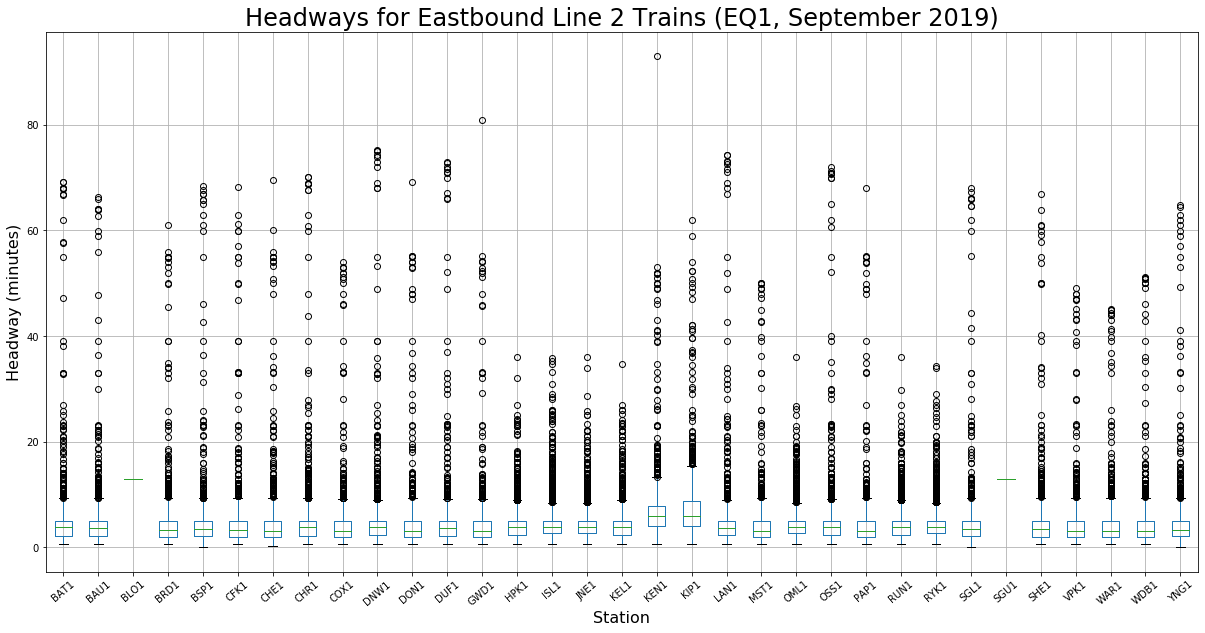

In [395]:
ax = ttc_east.boxplot(column = 'headway_m', by = 'station_char', rot=40)
fig = ax.get_figure()

fig.suptitle('')
ax.set_xlabel("Station",fontsize=16)
ax.set_ylabel("Headway (minutes)",fontsize=16)
ax.set_title("Headways for Eastbound Line 2 Trains (EQ1, September 2019)",fontsize=24)

In [396]:
ttc_east[['station_char','headway_m']].groupby('station_char').describe()

headway_m                                                    \
                 count       mean       std    min     25%    50%    75%   
station_char                                                               
BAT1            7732.0   3.990006  3.266582   0.58   2.130   3.73   5.00   
BAU1            7745.0   3.942265  3.082498   0.60   2.120   3.60   4.98   
BLO1               1.0  12.980000       NaN  12.98  12.980  12.98  12.98   
BRD1            7875.0   3.879195  2.962451   0.58   2.000   3.25   5.00   
BSP1            8122.0   3.796166  3.082409   0.00   2.120   3.38   4.98   
CFK1            7878.0   3.889506  3.088236   0.60   2.000   3.27   4.98   
CHE1            8065.0   3.796919  3.116044   0.25   2.000   3.12   4.98   
CHR1            7711.0   4.001726  3.309833   0.58   2.130   3.73   4.98   
COX1            8684.0   3.611103  2.804226   0.58   1.980   3.00   4.87   
DNW1            7902.0   3.920437  3.436949   0.58   2.250   3.73   4.98   
DON1            8217.0   3.718515  2.973904   0.58   2.000   3.00   4.98   
DUF1            7962.0   3.885485  3.307708   0.58   2.150   3.72   4.98   
GWD1            8861.0   3.534856  2.863800   0.58   1.980   3.00   4.87   
HPK1            7663.0   3.959661  2.262689   0.60   2.380   3.75   5.00   
ISL1            7331.0   4.131206  2.564836   0.58   2.730   3.88   5.00   
JNE1            7623.0   3.978226  2.248994   0.58   2.600   3.87   4.98   
KEL1            7798.0   3.911625  2.218533   0.60   2.270   3.73   4.98   
KEN1            5204.0   6.001699  4.091758   0.58   3.980   5.85   7.73   
KIP1            4802.0   6.565087  4.327866   0.58   4.000   6.00   8.73   
LAN1            7972.0   3.886049  3.371005   0.58   2.250   3.60   4.98   
MST1            8483.0   3.694876  2.758314   0.58   2.000   3.00   4.98   
OML1            7632.0   3.974177  2.216219   0.58   2.600   3.85   4.98   
OSS1            7779.0   3.973134  3.318067   0.58   2.215   3.75   4.98   
PAP1            8215.0   3.717951  2.979321   0.58   2.000   3.00   4.98   
RUN1            7661.0   3.959102  2.223415   0.58   2.380   3.87   4.98   
RYK1            7597.0   3.991845  2.263281   0.58   2.600   3.87   4.98   
SGL1            8113.0   3.794541  3.028864   0.12   2.120   3.38   4.98   
SGU1               1.0  12.980000       NaN  12.98  12.980  12.98  12.98   
SHE1            7829.0   3.917642  3.131153   0.60   2.000   3.38   4.98   
VPK1            8427.0   3.716696  2.741119   0.58   2.000   3.00   4.98   
WAR1            8427.0   3.714705  2.675751   0.60   2.000   3.00   4.98   
WDB1            8518.0   3.681374  2.780137   0.60   2.000   3.00   4.98   
YNG1            8010.0   3.818614  3.016038   0.00   2.100   3.25   4.98   

                     
                max  
station_char         
BAT1          69.13  
BAU1          66.37  
BLO1          12.98  
BRD1          60.98  
BSP1          68.40  
CFK1          68.25  
CHE1          69.60  
CHR1          70.12  
COX1          54.12  
DNW1          75.25  
DON1          69.27  
DUF1          73.00  
GWD1          81.00  
HPK1          36.12  
ISL1          35.75  
JNE1          36.02  
KEL1          34.72  
KEN1          93.00  
KIP1          61.98  
LAN1          74.38  
MST1          50.12  
OML1          35.98  
OSS1          72.00  
PAP1          68.00  
RUN1          35.98  
RYK1          34.38  
SGL1          68.00  
SGU1          12.98  
SHE1          66.98  
VPK1          49.12  
WAR1          45.12  
WDB1          51.25  
YNG1          64.87

Notes:
* *min* times are low because it doesn't include *timint* (or I messed up somewhere).
* BLO and SGU are probably errors/mispellings?

### Equation 2

In [398]:
headway2 = (pd.to_datetime(ttc_4['request_date']) + pd.to_timedelta(ttc_4['timint'],unit='m')) - (pd.to_datetime(ttc_4['request_date_prev'] ) + pd.to_timedelta(ttc_4['timint_prev'],unit='m'))

# make new dataset with relevant information
ttc_4['headway'] = headway2

ttc_east2 = ttc_4.drop(['request_date_prev','station_char_prev','timint_prev','timint','train_dest','id'],1).loc[ttc_4['headway'] < pd.to_timedelta(2,unit='h')]
ttc_east2['headway_m'] = (ttc_east2['headway'].astype('timedelta64[s]')/60).round(2)
ttc_east2.head(20)

,requestid,station_char,subwayline,system_message_type,traindirection,trainid,train_message,request_date,headway,headway_m
289986,51867,BAT1,BD,Normal,East,214,Arriving,2019-09-01 08:28:48.274270-04:00,00:08:16.985389,8.27
33968,5954,BAT1,BD,Normal,East,215,Arriving,2019-09-01 08:33:48.274114-04:00,00:05:26.718442,5.43
285213,51038,BAT1,BD,Normal,East,216,AtStation,2019-09-01 08:38:40.470984-04:00,00:04:08.492513,4.13
309482,55336,BAT1,BD,Normal,East,217,Arriving,2019-09-01 08:42:48.274624-04:00,00:04:24.789398,4.40
29550,5145,BAT1,BD,Normal,East,218,Arriving,2019-09-01 08:47:40.264634-04:00,00:04:51.990010,4.85
396654,71152,BAT1,BD,Normal,East,219,AtStation,2019-09-01 08:52:48.275606-04:00,00:04:51.025213,4.85
301689,53926,BAT1,BD,Normal,East,220,AtStation,2019-09-01 08:58:40.830111-04:00,00:05:52.554505,5.87
16117,2827,BAT1,BD,Normal,East,221,AtStation,2019-09-01 09:03:40.589501-04:00,00:04:59.759390,4.98
311831,55754,BAT1,BD,Normal,East,222,AtStation,2019-09-01 09:07:48.279869-04:00,00:04:07.690368,4.12
441563,79159,BAT1,BD,Normal,East,201,AtStation,2019-09-01 09:13:40.542054-04:00,00:05:52.262185,5.87


Text(0.5, 1.0, 'Headways for Eastbound Line 2 Trains (EQ2, September 2019)')

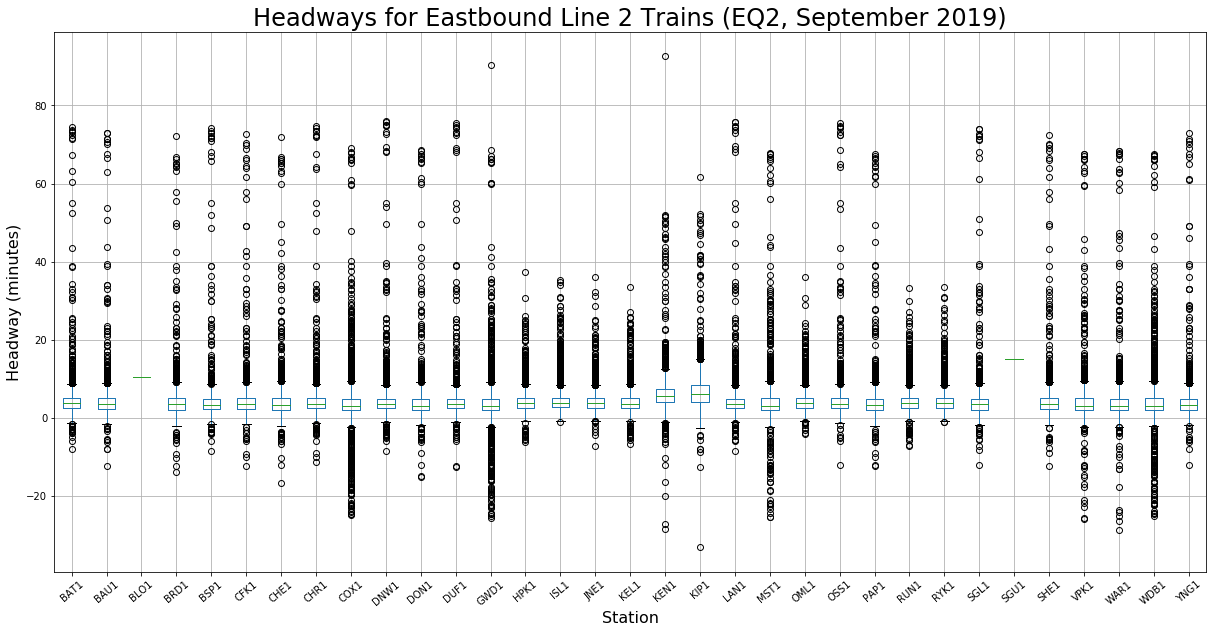

In [399]:
ax = ttc_east2.boxplot(column = 'headway_m', by = 'station_char', rot=40)
fig = ax.get_figure()

fig.suptitle('')
ax.set_xlabel("Station",fontsize=16)
ax.set_ylabel("Headway (minutes)",fontsize=16)
ax.set_title("Headways for Eastbound Line 2 Trains (EQ2, September 2019)",fontsize=24)

In [400]:
ttc_east2[['station_char','headway_m']].groupby('station_char').describe()

headway_m                                                     \
                 count       mean       std    min    25%    50%      75%   
station_char                                                                
BAT1            7732.0   4.006204  3.410500  -7.85   2.42   3.68   4.9800   
BAU1            7745.0   3.963371  3.325945 -12.22   2.33   3.55   4.9700   
BLO1               1.0  10.370000       NaN  10.37  10.37  10.37  10.3700   
BRD1            7875.0   3.907191  3.288016 -13.98   2.13   3.43   4.9800   
BSP1            8122.0   3.814730  3.307928  -8.38   2.28   3.40   4.8500   
CFK1            7878.0   3.912381  3.368617 -12.35   2.18   3.45   4.9800   
CHE1            8065.0   3.827520  3.479695 -16.78   2.00   3.27   4.9800   
CHR1            7711.0   4.015469  3.438162 -11.37   2.43   3.60   4.9800   
COX1            8684.0   3.637601  4.132390 -24.97   1.98   3.00   4.9500   
DNW1            7902.0   3.922830  3.461945  -8.53   2.43   3.58   4.8700   
DON1            8217.0   3.749906  3.382025 -15.22   2.00   3.13   4.9000   
DUF1            7962.0   3.892728  3.388339 -12.47   2.40   3.57   4.8700   
GWD1            8861.0   3.542363  4.151518 -25.58   1.98   3.07   4.8700   
HPK1            7663.0   3.961865  2.176892  -6.13   2.60   3.73   4.9800   
ISL1            7331.0   4.132234  2.516655  -0.97   2.68   3.75   4.9800   
JNE1            7623.0   3.981362  2.148513  -7.25   2.65   3.73   4.9800   
KEL1            7798.0   3.912417  2.155103  -6.60   2.58   3.67   4.9775   
KEN1            5204.0   5.984324  4.196430 -28.53   3.98   5.60   7.4500   
KIP1            4802.0   6.525993  4.207675 -33.12   4.00   6.00   8.4275   
LAN1            7972.0   3.891856  3.439837  -8.58   2.40   3.57   4.8000   
MST1            8483.0   3.728661  3.753012 -25.33   2.00   3.12   4.9800   
OML1            7632.0   3.976921  2.149224  -4.13   2.60   3.73   4.9800   
OSS1            7779.0   3.984121  3.403276 -12.15   2.48   3.67   4.9800   
PAP1            8215.0   3.747716  3.353593 -12.35   2.00   3.17   4.8900   
RUN1            7661.0   3.960664  2.152908  -7.18   2.62   3.72   4.9800   
RYK1            7597.0   3.993393  2.160670  -1.12   2.65   3.73   4.9800   
SGL1            8113.0   3.813377  3.288104 -12.08   2.13   3.45   4.8700   
SGU1               1.0  15.120000       NaN  15.12  15.12  15.12  15.1200   
SHE1            7829.0   3.943332  3.384386 -12.35   2.22   3.48   4.9800   
VPK1            8427.0   3.750650  3.530939 -26.00   2.00   3.10   4.9800   
WAR1            8427.0   3.749328  3.543082 -28.83   2.00   3.00   4.9400   
WDB1            8518.0   3.710969  4.003554 -25.10   2.00   3.12   4.9800   
YNG1            8010.0   3.841050  3.280861 -12.08   2.13   3.35   4.8775   

                     
                max  
station_char         
BAT1          74.40  
BAU1          73.05  
BLO1          10.37  
BRD1          72.23  
BSP1          74.35  
CFK1          72.77  
CHE1          72.05  
CHR1          74.63  
COX1          69.18  
DNW1          75.95  
DON1          68.58  
DUF1          75.52  
GWD1          90.43  
HPK1          37.38  
ISL1          35.23  
JNE1          35.97  
KEL1          33.45  
KEN1          92.60  
KIP1          61.68  
LAN1          75.73  
MST1          67.73  
OML1          35.98  
OSS1          75.53  
PAP1          67.68  
RUN1          33.18  
RYK1          33.62  
SGL1          74.10  
SGU1          15.12  
SHE1          72.33  
VPK1          67.67  
WAR1          68.37  
WDB1          67.52  
YNG1          72.90

Note:
* The differences of the means of the equations are very small (at a glance), so does it really matter if I just pick the first equation instead of modelling *timint*? I could look into more statistical tests to see which one is really the better option.